In [10]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [2]:
o20 = pd.read_csv('./ArgusaChallenge2023/orders_2020.csv')
o21 = pd.read_csv('./ArgusaChallenge2023/orders_2021.csv')
o22 = pd.read_csv('./ArgusaChallenge2023/orders_2022.csv')
o23 = pd.read_csv('./ArgusaChallenge2023/orders_2023.csv')
clients = pd.read_csv('./ArgusaChallenge2023/clients.csv')
ratings = pd.read_csv('./ArgusaChallenge2023/ratings.csv')
returns = pd.read_csv('./ArgusaChallenge2023/returns.csv')

products=pd.read_csv('./ArgusaChallenge2023/products.csv')
total_revenues = 46449091

In [3]:
# Adding the column with the price of selling to the table with each year
p_startdate=pd.to_datetime(products['start_date']).values
p_startdate=np.array(p_startdate,dtype=np.datetime64)

p_enddate=pd.to_datetime(products['end_date']).values
p_enddate=np.array(p_enddate,dtype=np.datetime64)
total=0
for year in [2020, 2021, 2022, 2023]:
    if year==2020: data=pd.DataFrame.copy(o20)
    elif year==2021: data=pd.DataFrame.copy(o21)
    elif year==2022: data=pd.DataFrame.copy(o22)
    elif year==2023: data=pd.DataFrame.copy(o23)

    data['price_sold'] = None
    dates_year = pd.to_datetime(data['order_date']).values
    dates_year=np.array(dates_year,dtype=np.datetime64)

    prices = np.array([])
    for (ind_order, date) in enumerate(dates_year):
        if data['order_id'][ind_order] in returns['order_id'].values:
            prices=np.append(prices, 0); 
            continue
        ind_prod = data['product_id'][ind_order]
        ind_sold = np.where((date<=p_enddate)&(date>=p_startdate)&(products['id'].values==ind_prod))
        if np.size(ind_sold)==0:
            prices=np.append(prices, 0)
        else: 
            prices=np.append(prices, products['sale_price'][ind_sold[0]])
    data['price_sold']=prices
    total+=np.sum(prices)
    if year==2020: o20_new=data
    elif year==2021: o21_new=data
    elif year==2022: o22_new=data
    elif year==2023: o23_new=data

print(total/total_revenues)

## the total is not right, we are not sure what went wrong. 

0.8470088314537737


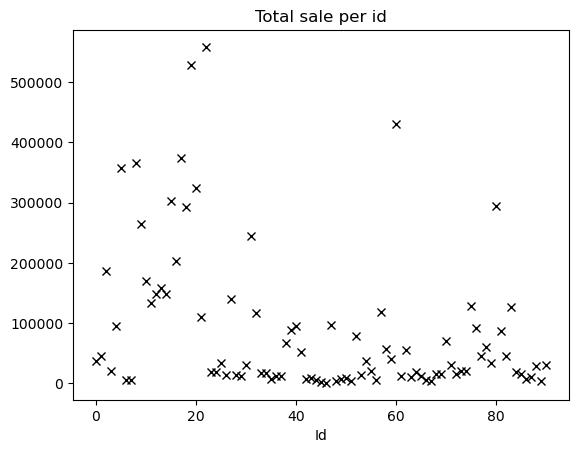

In [4]:
#### Question 2 ####
####################
total_sale = []
ids = o23_new['product_id'].unique()
for id in ids:
   sales = o23_new['price_sold'].loc[o23_new['product_id'] == id]
   total_sale.append(sales.sum())


# plot id tolat sales
fig, ax = plt.subplots()
ax.plot(ids,total_sale,"kx")
ax.set_title('Total sale per id')
ax.set_xlabel('Id')
plt.show()  


# max sales id 22
max_sale_id = ids[np.argmax(total_sale)]


# get product name
product1_name = products['name'].loc[products['id'] == max_sale_id].iloc[0]
# product name is
#Samsung QE85Q60BA, 4K, QLED, 2022, 85

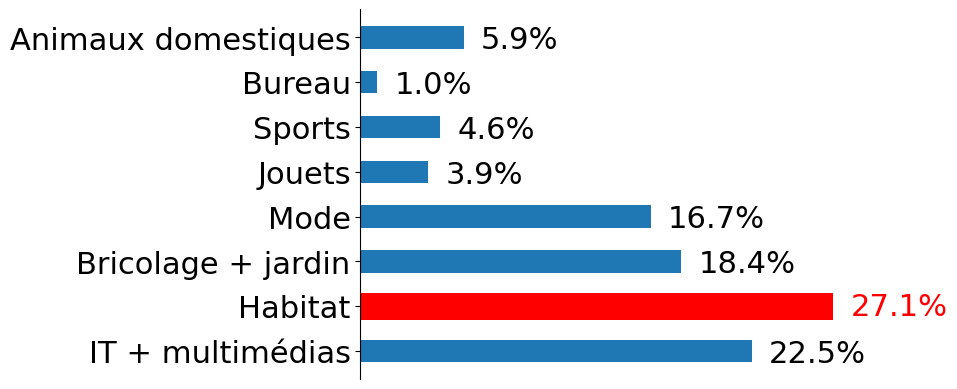

In [81]:
#### Question 3 ####
####################
categories = products['category_1'].unique()
returns_id = []
for cat in categories:
     cat_id = products.loc[products['category_1'] == cat]['id']
     returns_id.append(returns[returns['product_id'].isin(cat_id)].shape[0])
   

# Sum returns for each cat
fig, ax = plt.subplots()
ax.barh(categories, returns_id/np.sum(returns_id), height=0.5)
ax.barh(categories[1], returns_id[1]/np.sum(returns_id), color='red', height=0.6)
for i in range(np.size(returns_id)):
    if i==1: continue
    ax.text(returns_id[i]/np.sum(returns_id)+0.01, i-0.25, f'{returns_id[i]/np.sum(returns_id)*100:.1f}%')
    
ax.text(returns_id[1]/np.sum(returns_id)+0.01, 0.8, f'{returns_id[1]/np.sum(returns_id)*100:.1f}%', color='red')
#ax.set_yticklabels(categories.iloc)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.set_xlabel('Returned products (%)')
plt.show()

In [ ]:
#### Question 4 ####
####################
clients['n_ret_items'] = None
clients['n_buy_items'] = None
n_ret_items = np.array([])
n_buy_items = np.array([])
for year in [2020, 2021, 2022, 2023]:
    if year==2020: data=pd.DataFrame.copy(o20_new)
    elif year==2021: data=pd.DataFrame.copy(o21_new)
    elif year==2022: data=pd.DataFrame.copy(o22_new)
    elif year==2023: data=pd.DataFrame.copy(o23_new)

    client_buy = np.array([])
    client_return = np.array([])

    for ii, cl_id in enumerate(clients['client_id'].values):
        ind_ord_clients = np.where(data['client_id'].values==cl_id)[0]
        client_buy=np.append(client_buy, np.sum(data['price_sold'][ind_ord_clients].values))
        ret=0;
        for o_ret in ind_ord_clients:
            if o_ret in returns['order_id'].values:
                ret  += data['price_sold'][o_ret].values
        client_return=np.append(client_return, ret)
    if year==2020: clients['buy_2020']=client_buy; clients['ret_2020']=client_return; clients['net_2020']=client_buy-client_return
    elif year==2021: clients['buy_2021']=client_buy; clients['ret_2021']=client_return; clients['net_2021']=client_buy-client_return
    elif year==2022: clients['buy_2022']=client_buy; clients['ret_2022']=client_return; clients['net_2022']=client_buy-client_return
    elif year==2023: clients['buy_2023']=client_buy; clients['ret_2023']=client_return; clients['net_2023']=client_buy-client_return

clients['buy_total']=clients['buy_2020']+clients['buy_2021']+clients['buy_2022']+clients['buy_2023']
clients['ret_total']=clients['ret_2020']+clients['ret_2021']+clients['ret_2022']+clients['ret_2023']
clients['net_total']=clients['net_2020']+clients['net_2021']+clients['net_2022']+clients['net_2023']

In [93]:
clients_sorted = clients.sort_values(by='net_total', ascending=False)
# Printing first three clients with ID, name and revenue
for i in [0,1,2]:
    print(clients_sorted.iloc[i]['client_id'],clients_sorted.iloc[i]['last_name'], clients_sorted.iloc[i]['fisrt_name'], clients_sorted.iloc[i]['net_total'])
    
#A4-819583b Delèze François 32148.409999999996
#V0-0674179j Jacot-Guillarmod Jonathan 24848.71
#u0-8614055c Rappaz Jean 24245.170000000002

A4-819583b Delèze François 32148.409999999996
V0-0674179j Jacot-Guillarmod Jonathan 24848.71
u0-8614055c Rappaz Jean 24245.170000000002


Text(0, 0.5, 'Net revenue (k$)')

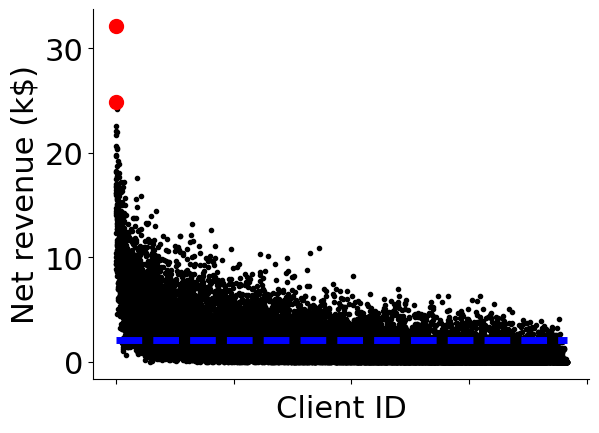

In [112]:
# scatter plot of their revenue
fig, ax =plt.subplots()
ax.plot(clients['net_total']*1e-3, 'k.')
ax.plot(clients_sorted['net_total'][0:2]*1e-3, 'ro', markersize=10)
ax.plot([0,np.size(clients['net_total'])], [np.mean(clients['net_total']*1e-3), np.mean(clients['net_total']*1e-3)], 'b--', linewidth=5)
ax.set_xlabel('Client ID')
ax.xaxis.set_ticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.set_ylabel('Net revenue (k$)')

In [ ]:
#### Question 5 ####
####################
n_ret_items = np.array([])
n_buy_items = np.array([])
total_ret=np.zeros(np.size(clients['client_id']))
total_buy =np.zeros(np.size(clients['client_id']))
for year in [2020, 2021, 2022, 2023]:
    if year==2020: data=pd.DataFrame.copy(o20_new)
    elif year==2021: data=pd.DataFrame.copy(o21_new)
    elif year==2022: data=pd.DataFrame.copy(o22_new)
    elif year==2023: data=pd.DataFrame.copy(o23_new)

    client_buy = np.array([])
    client_return = np.array([])

    for ii, cl_id in enumerate(clients['client_id'].values):
        ind_ord_clients = np.where(data['client_id'].values==cl_id)[0]
        n_buy=np.size(ind_ord_clients)
        year_buy = np.append(client_buy, n_buy)
        
        n_ret=0;
        for o_ret in data['order_id'][ind_ord_clients]:
            if o_ret in returns['order_id'].values:
                n_ret+=1
        year_return=np.append(client_return, n_ret)
    print(np.size(total_ret), np.size(year_return))
    total_ret = total_ret+year_return
    total_buy = total_buy+year_buy

In [130]:
print(np.sort(total_ret))

[0. 0. 0. ... 0. 0. 0.]
